<p>
    DESCRIPTION

Reduce the time a Mercedes-Benz spends on the test bench.

Problem Statement Scenario:
Since the first automobile, the Benz Patent Motor Car in 1886, Mercedes-Benz has stood for important automotive innovations. These include the passenger safety cell with a crumple zone, the airbag, and intelligent assistance systems. Mercedes-Benz applies for nearly 2000 patents per year, making the brand the European leader among premium carmakers. Mercedes-Benz is the leader in the premium car industry. With a huge selection of features and options, customers can choose the customized Mercedes-Benz of their dreams.

To ensure the safety and reliability of every unique car configuration before they hit the road, the company’s engineers have developed a robust testing system. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Mercedes-Benz’s production lines. However, optimizing the speed of their testing system for many possible feature combinations is complex and time-consuming without a powerful algorithmic approach.

You are required to reduce the time that cars spend on the test bench. Others will work with a dataset representing different permutations of features in a Mercedes-Benz car to predict the time it takes to pass testing. Optimal algorithms will contribute to faster testing, resulting in lower carbon dioxide emissions without reducing Mercedes-Benz’s standards.

Following actions should be performed:

    If for any column(s), the variance is equal to zero, then you need to remove those variable(s).
    Check for null and unique values for test and train sets.
    Apply label encoder.
    Perform dimensionality reduction.
    Predict your test_df values using XGBoost.
</p>

In [1]:
import numpy as np 
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
#read in training data
train_df = pd.read_csv('_data/merc_train.csv')
print('Size of training set: {} rows and {} columns'.format(*train_df.shape))
train_df.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df = pd.read_csv('_data/merc_test.csv')
print('Size of training set: {} rows and {} columns'.format(*test_df.shape))
test_df.head()

Size of training set: 4209 rows and 377 columns


,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


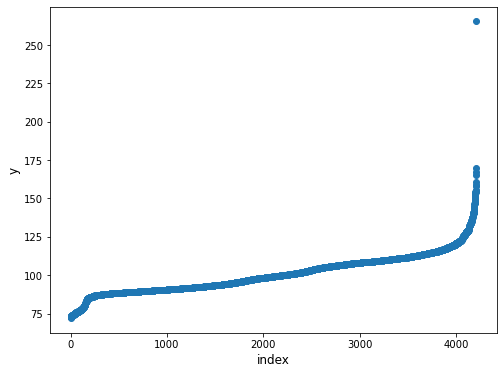

In [5]:
#plot data

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

In [6]:
# removing the outlier
train_df = train_df.loc[train_df['y'] < 200, :]

In [7]:
# seperating label and features
y_train = train_df['y']
x_train = train_df.drop('y', axis=1)

In [8]:
#check data types
dtype_x = x_train.dtypes.reset_index()
dtype_x.columns = ["Count", "Column Type"]
dtype_x.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,object,8


In [20]:
#see what those objects are

dtype_objects = [col for col in x_train.columns if x_train[col].dtypes == 'object']

print(dtype_objects)

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


In [21]:
#check for null values
print('train: ',train_df.isnull().values.any())
print('testing',test_df.isnull().values.any())

train:  False
testing False


In [22]:
#checl for unique values
unique_values_dict = {}
for col in x_train.columns:
    if col not in ["ID", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        unique_value = str(np.sort(x_train[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

Columns containing the unique values :  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145'

In [24]:
#If for any column(s), the variance is equal to zero, then you need to remove those variable(s)
        
col_var_is_zero = [col for col in x_train.columns[10:] if x_train.var()[col]==0]
print('columns with variance == zero:',len(col_var_is_zero))

columns with variance == zero: 12


In [26]:
#remove variables
for col in col_var_is_zero:
    x_train = x_train.drop(col,1)
    test_df = test_df.drop(col,1)
print('x train shape',x_train.shape)
print('testing shape',test_df.shape)

x train shape (4208, 365)
testing shape (4209, 365)


In [27]:
#Apply label encoder.

# label encoding the categorical features for dimension reduction
for col in x_train.columns[:12]:
    if x_train[col].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(x_train[col].values) + list(test_df[col].values))
        x_train[col] = lbl.transform(list(x_train[col].values))
        test_df[col] = lbl.transform(list(test_df[col].values))

In [28]:
#Perform dimensionality reduction.
n_comp = 12
# PCA
pca = PCA(n_components=n_comp, random_state=123)
pca.fit_transform(x_train)
x_train_transformed = pca.transform(x_train)
print('train: ',x_train_transformed.shape)

test_transform = pca.transform(test_df)
print('test: ',test_transform.shape)

(4208, 12)


In [34]:
#Predict your test_df values using XGBoost.

xgb_params = {
        'n_trees': 520, 
        'eta': 0.0045,
        'max_depth': 4,
        'subsample': 0.93,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'base_score': np.mean(y_train),
        }

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(test_df)

num_boost_rounds = 1250
model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)
predictions = model.predict(dtest)


[00:22:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:22:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_trees } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:22:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [35]:
predictions

array([ 82.55332, 104.63226,  80.45997, ...,  93.25829, 109.64236,
        94.00259], dtype=float32)